In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
import os
basePath = '/content/gdrive/My Drive/'
os.chdir(basePath + '5AbstractsGroup')

## S-BERT

In [ ]:
!pip install --quiet sentence-transformers

     |████████████████████████████████| 71kB 7.2MB/s 
     |████████████████████████████████| 1.8MB 11.0MB/s 
     |████████████████████████████████| 1.2MB 53.6MB/s 
     |████████████████████████████████| 2.9MB 51.9MB/s 
     |████████████████████████████████| 890kB 53.2MB/s 


In [ ]:
from sentence_transformers import SentenceTransformer
device = 'cuda'
evalModel = SentenceTransformer('bert-base-nli-mean-tokens')
evalModel = evalModel.to(device)

100%|██████████| 405M/405M [00:15<00:00, 25.8MB/s]


## USE

In [ ]:
!pip3 install --quiet tensorflow-hub
!pip3 install --quiet seaborn
!pip3 install --quiet transformers

     |████████████████████████████████| 2.5MB 8.4MB/s 
     |████████████████████████████████| 3.3MB 43.7MB/s 
     |████████████████████████████████| 901kB 46.0MB/s 


In [ ]:
#Load the Universal Sentence Encoder's TF Hub module
from absl import logging

import tensorflow as tf

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
modelEval2 = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return modelEval2(input)

module https://tfhub.dev/google/universal-sentence-encoder-large/5 loaded


## Helper functions

In [ ]:
import torch
cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)

In [ ]:
def getEmbedding(sntcBatch):
    # return evalModel.encode(sntcBatch, convert_to_tensor=True)
    return torch.tensor(np.asarray(embed(sntcBatch)))

In [ ]:
# Similar to the above, for whole documents instead of sentences.
# The embedding of the document is calculated as the average of all its sentences
def getDocumentEmbedding(documentBatch):
  docEmbeddings = torch.zeros(len(documentBatch), 512)
  for (i, doc) in enumerate(documentBatch):
    sentences = tokenize.sent_tokenize(doc)
    sentEmbeddings = getEmbedding(sentences)
    avgEmbedding = torch.mean(sentEmbeddings, axis=0)
    docEmbeddings[i, :] = avgEmbedding
  return docEmbeddings

In [ ]:
def getSimilarity(a, b):
  return cos(a, b)
  # return np.linalg.norm(a - b, -1)

In [ ]:
def evaluateEmbeddingsMultiple(generatedEmbeddingsArr, evaluationEmbeddingsArr):
  nSentences = len(generatedEmbeddingsArr)
  nKeywords  = len(evaluationEmbeddingsArr)
  scores = torch.zeros(size=(nSentences, 1))

  for i in range(nSentences):
    for j in range(nKeywords):
      scores[i] += getSimilarity(evaluationEmbeddingsArr[j], generatedEmbeddingsArr[i]) 
    scores[i] = scores[i]/nKeywords

  score = torch.mean(scores)
  std = torch.std(scores)

  return score, std, scores

In [ ]:
def choose_from_top(probs, n=40):
    ind = np.argpartition(probs, -n)[-n:]
    top_prob = probs[ind]
    top_prob = top_prob / np.sum(top_prob) # Normalize
    choice = np.random.choice(n, 1, p = top_prob)
    token_id = ind[choice][0]
    return int(token_id)

In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
device = 'cuda'
tokenizer = GPT2Tokenizer.from_pretrained('gpt2-medium')
model = GPT2LMHeadModel.from_pretrained('gpt2-medium')
model = model.to(device)

In [ ]:
  def generate(model=model, prompt='<|endoftext|>', nSentences=20, showOnlyFinished=0, n=40):
  #   """
  #   Function GENERATE()
  #   INPUTS:
  #     model           : Pytorch Model     - Pytorch Language Model to use
  #     prompt          : String            - User prompt 
  #     nSentences      : Int               - Number of sentences to generate
  #     showOnlyFinished: Boolean           - Wether to display only generated sentences that end with <|endoftext|>
  #     n               : Int               - top-n sampler parameter. Set higher for more diversity, but too high will produce nonsense

  #   AUTHOR: Kitsios Konstantinos
  #   """

      # Turn model in evaluation mode(deactivate dropouts etc)
      model.eval()
      # Number of sentences generated so far
      gen_num = 0
      # Array to return
      generatedSentenceArr = []
      # Tokenizer(Suppose GPT2 model)
      tokenizer = GPT2Tokenizer.from_pretrained('gpt2-medium')

      with torch.no_grad():

              # How many sentences to generate
              for gen_idx in range(nSentences):
                  # Generation not finished yet
                  gen_finished = False

                  # Define custom prompt
                  cur_ids = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0).to(device)

                  # Predict the next 50 words(unless EOS token encountered)
                  for i in range(10):
                      # Forward pass the model to get outputs
                      outputs = model(cur_ids, labels=cur_ids)
                      # Get logits
                      loss, logits = outputs[:2]
                      # Transform logits to probabilities
                      softmax_logits = torch.softmax(logits[0, -1], dim=0) #Take the first(from only one in this case) batch and the last predicted embedding
                      # Sample using top-n sampler
                      next_token_id = choose_from_top(softmax_logits.to('cpu').numpy(), n=n) #Randomly(from the topN probability distribution) select the next word
                      cur_ids = torch.cat([cur_ids, torch.ones((1,1)).long().to(device) * next_token_id], dim = 1) # Add the last word to the running sequence

                      if next_token_id in tokenizer.encode('<|endoftext|>'):
                          gen_finished = True
                          break

                  
                  if gen_finished or not showOnlyFinished:
                      
                      gen_num = gen_num + 1
                      
                      output_list = list(cur_ids.squeeze().to('cpu').numpy())
                      output_text = tokenizer.decode(output_list)
                      generatedSentenceArr.append(output_text.replace('<|endoftext|>', ''))
      return generatedSentenceArr

## Preparation

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch
from nltk import tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [11]:
topicsKeys = ['Law', 'Sociology', 'Business', 'Trans', 'CSAI']
topics = ['Law', 'Sociology', 'Business', 'Transportation', 'Computer Science']
print(topics)

['Law', 'Sociology', 'Business', 'Transportation', 'Computer Science']


In [13]:
df = pd.DataFrame()
for (i, fname) in enumerate(topicsKeys):
  with open(fname+'.txt', 'r') as f:
    # df = pd.concat( [df,  pd.DataFrame(data={'text':f.readlines()[0:1000], 'label': i})] )
    df = pd.concat( [df,  pd.DataFrame(data={'text':f.readlines(), 'label': i, 'labelText': topics[i]})] )

In [14]:
df.sample(5)

text  label       labelText
1257   the impact of path selection on ghg emissions...      3  Transportation
541    microbial suicide  towards a less anthropocen...      1       Sociology
1373   two phase decomposition method for the last t...      3  Transportation
680    liquid consumption this article introduces a ...      2        Business
36      i won t take part    exploring the multiple ...      1       Sociology

In [ ]:
df.groupby('label').count().text

label
0    1006
1    1072
2    1252
3    1448
4    1468
Name: text, dtype: int64

Text(0, 0.5, 'Frequency')

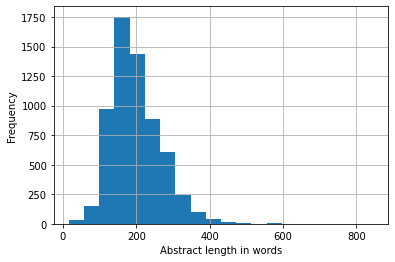

In [ ]:
ax = df['text'].str.split().str.len().hist(bins=20)
ax.set_xlabel('Abstract length in words')
ax.set_ylabel('Frequency')

In [ ]:
# nWordsToKeep = 30
# df['text'] = df['text'].apply(lambda x: ' '.join(x.split()[:nWordsToKeep]))

In [ ]:
nSentences = len(df)
nSentences

6246

In [ ]:
textEmbeddings = getDocumentEmbedding(list(df['text']))

In [ ]:
# torch.save(textEmbeddings, '5AbstractsEmbeddings.pt')

In [ ]:
textEmbeddings = torch.load('5AbstractsEmbeddings.pt')

### Visualization

In [3]:
!pip install hdf5storage

     |████████████████████████████████| 61kB 6.1MB/s 


In [4]:
import hdf5storage
mat = hdf5storage.loadmat('5AbstractsDataset_sgtsnepi.mat')

In [5]:
embeddings2D = mat['Y']

In [6]:
embeddings2D.shape

(6246, 2)

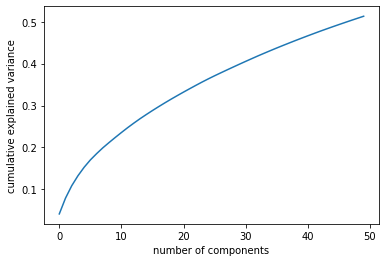

In [ ]:
# pca = PCA(n_components=50)
# embeddingsPCA = pca.fit_transform(textEmbeddings)

# plt.plot(np.cumsum(pca.explained_variance_ratio_))
# plt.xlabel('number of components')
# plt.ylabel('cumulative explained variance');

In [ ]:
# embeddings2D = TSNE(n_components=2).fit_transform(embeddingsPCA)

In [22]:
dfBokeh = pd.DataFrame(data={
    'x': embeddings2D[:, 0],
    'y': embeddings2D[:, 1],
    'text': list(df['text']),
    'label': list(df['label']),
    'labelText': list(df['labelText'])
})

In [23]:
dfBokeh['color'] = 'black'
dfBokeh.loc[dfBokeh['label']==0   , 'color'] = 'lightcoral'
dfBokeh.loc[dfBokeh['label']==1   , 'color'] = 'khaki'
dfBokeh.loc[dfBokeh['label']==2   , 'color'] = 'lightskyblue'
dfBokeh.loc[dfBokeh['label']==3   , 'color'] = 'olive'
dfBokeh.loc[dfBokeh['label']==4   , 'color'] = ' slategray'
# dfBokeh.loc[dfBokeh['label']==-1   , 'color'] = 'black'

dfBokeh['size'] = 4
# dfBokeh.loc[dfBokeh['label']==-1   , 'size'] = 10


In [24]:
# Bokeh Libraries
from bokeh.io import output_notebook, output_file, save
from bokeh.plotting import figure, show
from bokeh.models import HoverTool, OpenURL, TapTool
from bokeh.models import ColumnDataSource, CustomJS
from bokeh.models import TextInput, Button, Div, Slider, Paragraph
from bokeh.layouts import column, row
from bokeh import events
from bokeh.core.properties import value
from bokeh.events import MouseWheel
from bokeh.models.glyphs import Text, Circle, Glyph, ImageURL
from bokeh.util.browser import view
from bokeh.transform import linear_cmap
from bokeh.palettes import Spectral6, Turbo256



# Output thevisualization directly in the notebook
output_notebook()
output_file('/content/5Abstracts.html')

In [25]:
fig = figure(plot_height=550, plot_width=700, 
          match_aspect=True, title='2D embeddings 5AbstractsGroup documents')
# fig.title.text_font_style = 'bold'
# fig.title.align = 'center'
fig.xgrid.visible=False
fig.ygrid.visible=False


cds = ColumnDataSource(dfBokeh)
circleRenderer = fig.circle(x='x', y='y', legend='labelText', size='size', source=cds, color='color')

# Format the tooltip
tooltips = """
<div style="width:400px;">
@text
</div>
"""
# Add the HoverTool to the figure
hover = HoverTool(tooltips=tooltips, renderers=[circleRenderer])
fig.add_tools(hover)
show(fig)
save(fig)

'/content/5Abstracts.html'

### Artificial Labels

In [ ]:
# Generate new sentences from each topic
relatedEmbeddings = []
relatedSentencesArr = []
nRelatedSentences = 100
for (iTopic, topic) in enumerate(topics):
  print(topic)

  # M1
  relatedSentences = [topic]
  relatedSentencesArr.append(relatedSentences)

  # # M2
  # relatedSentences = [topic]
  # if topic == 'Computer Science':
  #   mostSimilar = glove_vectors.most_similar('science', topn=10)
  # else:
  #   mostSimilar = glove_vectors.most_similar(topic.lower(), topn=10)

  # for similarWord in mostSimilar:
  #   relatedSentences.append(similarWord[0])

  # # M3
  # relatedSentences = generate(model, prompt='In summary, ' + topic.lower(), n=40, nSentences=nRelatedSentences)
  # # relatedSentences = relatedSentences + generate(model, prompt=topic, n=40, nSentences=nRelatedSentences)
  # relatedSentencesArr.append(relatedSentences)
  # # relatedSentences = [x.replace('\n', ' ') for x in relatedSentences]

  relatedEmbeddings.append(getEmbedding(relatedSentences))

  # np.save(topic+'_USE_100', relatedEmbeddings[iTopic])
  # with open(topic+'_USE_Raw.txt', 'w') as f:
  #   f.write( '\n'.join(relatedSentences) )

Law
Sociology
Business
Transportation
Computer Science


In [ ]:
# Used saved sentences
relatedEmbeddings = []
relatedSentencesArr = []

for (iTopic, topic) in enumerate(topics):
  print(topic)
  relatedEmbeddings.append(np.load(topic+'_USE_200.npy'))

  with open(topic+'_USE_Raw.txt', 'r') as f:
    relatedSentencesArr.append(f.readlines())

Law
Sociology
Business
Transportation
Computer Science


In [ ]:
nRelatedSentences = len(relatedEmbeddings[1])

In [ ]:
nRelatedSentences

1

#### Average related embedding
---

In [ ]:
avgEmbeddings = []
for (iTopic, topic) in enumerate(topics):
  idx = list(df['label']==iTopic)
  avgEmbeddings.append( torch.mean(textEmbeddings[ idx, : ][0:50], dim=0) )

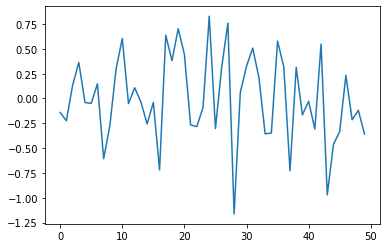

In [ ]:
plt.plot(avgEmbeddings[0][100:150])

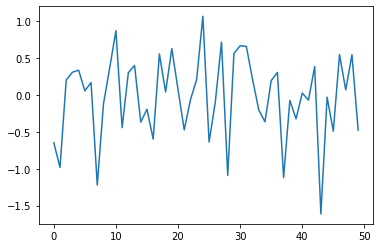

In [ ]:
plt.plot(textEmbeddings[0][100:150])

In [ ]:
relatedEmbeddings = []
for i in range(len(topics)):
  relatedEmbeddings.append(torch.reshape(avgEmbeddings[i], (1, -1)))

nRelatedSentences = 1

### Related sentences from training set
---

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train, test = train_test_split(df, test_size=0.2)

In [ ]:
relatedSentencesArr  = []
relatedEmbeddings    = []
nRelatedSentencesArr = []
for (iTopic, topic) in enumerate(topics):
  print(topic)
  idx = list( train['label']==iTopic )
  relatedSentences = list(train[idx]['text'])
  relatedSentencesArr.append( relatedSentences )
  relatedEmbeddings.append( getEmbedding(relatedSentences) )
  nRelatedSentencesArr.append( len(relatedSentences) )

Law
Sociology
Business
Transportation
Computer Science


In [ ]:
nRelatedSentencesArr

[796, 859, 995, 1147, 1199]

In [ ]:
df = test
nSentences = len(df)
textEmbeddings = getEmbedding(list(df['text']))

---

In [ ]:
textEmbeddings.shape

torch.Size([1250, 768])

In [ ]:
relatedEmbeddings[4].shape

torch.Size([1199, 768])

### PCA

In [ ]:
allEmbeddings = textEmbeddings
for (iTopic, topic) in enumerate(topics):
  print(topic)
  allEmbeddings = np.concatenate([allEmbeddings, relatedEmbeddings[iTopic]])

Law
Sociology
Business
Transportation
Computer Science


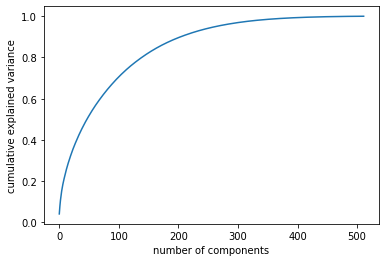

In [ ]:
pca = PCA(n_components=512)
embeddingsPCA = pca.fit_transform(allEmbeddings)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [ ]:
relatedEmbeddingsPCA = []
for (iTopic, topic) in enumerate(topics):
  relatedEmbeddingsPCA.append( torch.tensor(embeddingsPCA[nSentences + iTopic*nRelatedSentences : nSentences+(iTopic+1)*nRelatedSentences]) )

embeddingsArr = torch.tensor(embeddingsPCA[0:nSentences])

In [ ]:
# df = test
nSentences = len(df)
nSentences

6246

In [ ]:
len(relatedSentencesArr[0])

1

### Mean over related sentences aggregation

In [ ]:
probabilities = torch.zeros(size=(len(df), len(topics)))
# Uncomment to avoid using PCA
# embeddingsArr = textEmbeddings

for (iTopic, topic) in enumerate(topics):
  print(topic)
  evaluationEmbeddings = relatedEmbeddingsPCA[iTopic]

  # meanScore, std, proba = evaluateEmbeddingsMultiple(torch.tensor(textEmbeddings), torch.tensor(evaluationEmbeddings))
  meanScore, std, proba = evaluateEmbeddingsMultiple(torch.tensor(embeddingsArr), torch.tensor(evaluationEmbeddings))

  # meanScore, std, proba = evaluateEmbeddingsMultiple(torch.tensor(embeddingsPCA[0:nSentences]), torch.tensor(embeddingsPCA[nSentences + iTopic*nRelatedSentences : nSentences+(iTopic+1)*nRelatedSentences]))

  probabilities[:, iTopic] = proba.T



ypred = torch.argmax(probabilities, dim=1)

y = df['label']

Law


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


Sociology
Business
Transportation
Computer Science


In [ ]:
print(accuracy_score(y, ypred))

0.611591418507845


Text(123.0, 0.5, 'Actual')

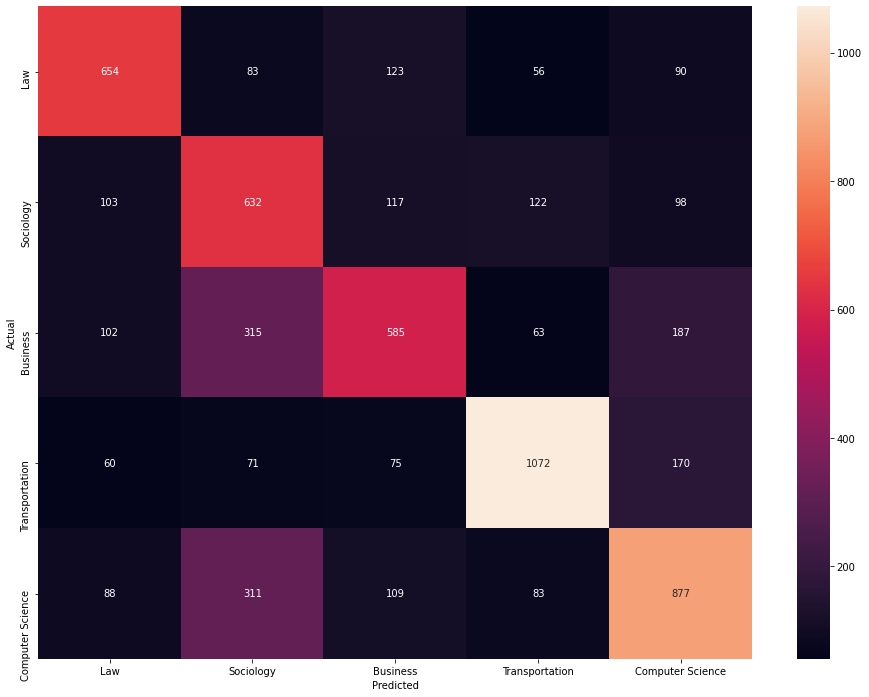

In [ ]:
cm = confusion_matrix(y, ypred)
cmNorm = torch.tensor(data=cm, dtype=float)
for i in range(len(cm)):
  cmNorm[i, :] = cmNorm[i, :]/torch.sum(cmNorm[i, :])

plt.figure(figsize=(16, 12))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=topics, yticklabels=topics)
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [ ]:
print(precision_score(y, ypred, average=None))
print('Precision: {:0.3f}'.format(np.mean(precision_score(y, ypred, average='weighted'))))

print(recall_score(y, ypred, average=None))
print('Recall: {:0.3f}'.format(np.mean(recall_score(y, ypred, average='weighted'))))

print(f1_score(y, ypred, average=None))
print('F1: {:0.3f}'.format(np.mean(f1_score(y, ypred, average='weighted'))))

[0.58479532 0.46462264 0.62716763 0.82813583 0.71604938]
Precision: 0.660
[0.69582505 0.55130597 0.51996805 0.82527624 0.63215259]
Recall: 0.651
[0.63549705 0.50426621 0.56855895 0.82670356 0.67149059]
F1: 0.652


In [ ]:
confusionMatrixNorm = torch.tensor(data=cm, dtype=float)
for i in range(len(cm)):
  confusionMatrixNorm[i, :] = confusionMatrixNorm[i, :]/torch.sum(confusionMatrixNorm[i, :])

In [ ]:
confusionMatrixNorm

tensor([[0.2177, 0.1402, 0.2724, 0.1620, 0.2078],
        [0.2174, 0.2537, 0.1007, 0.3433, 0.0849],
        [0.1438, 0.3818, 0.1573, 0.2204, 0.0966],
        [0.3039, 0.1015, 0.1934, 0.1236, 0.2776],
        [0.2255, 0.1798, 0.1315, 0.1390, 0.3243]], dtype=torch.float64)

<BarContainer object of 5 artists>

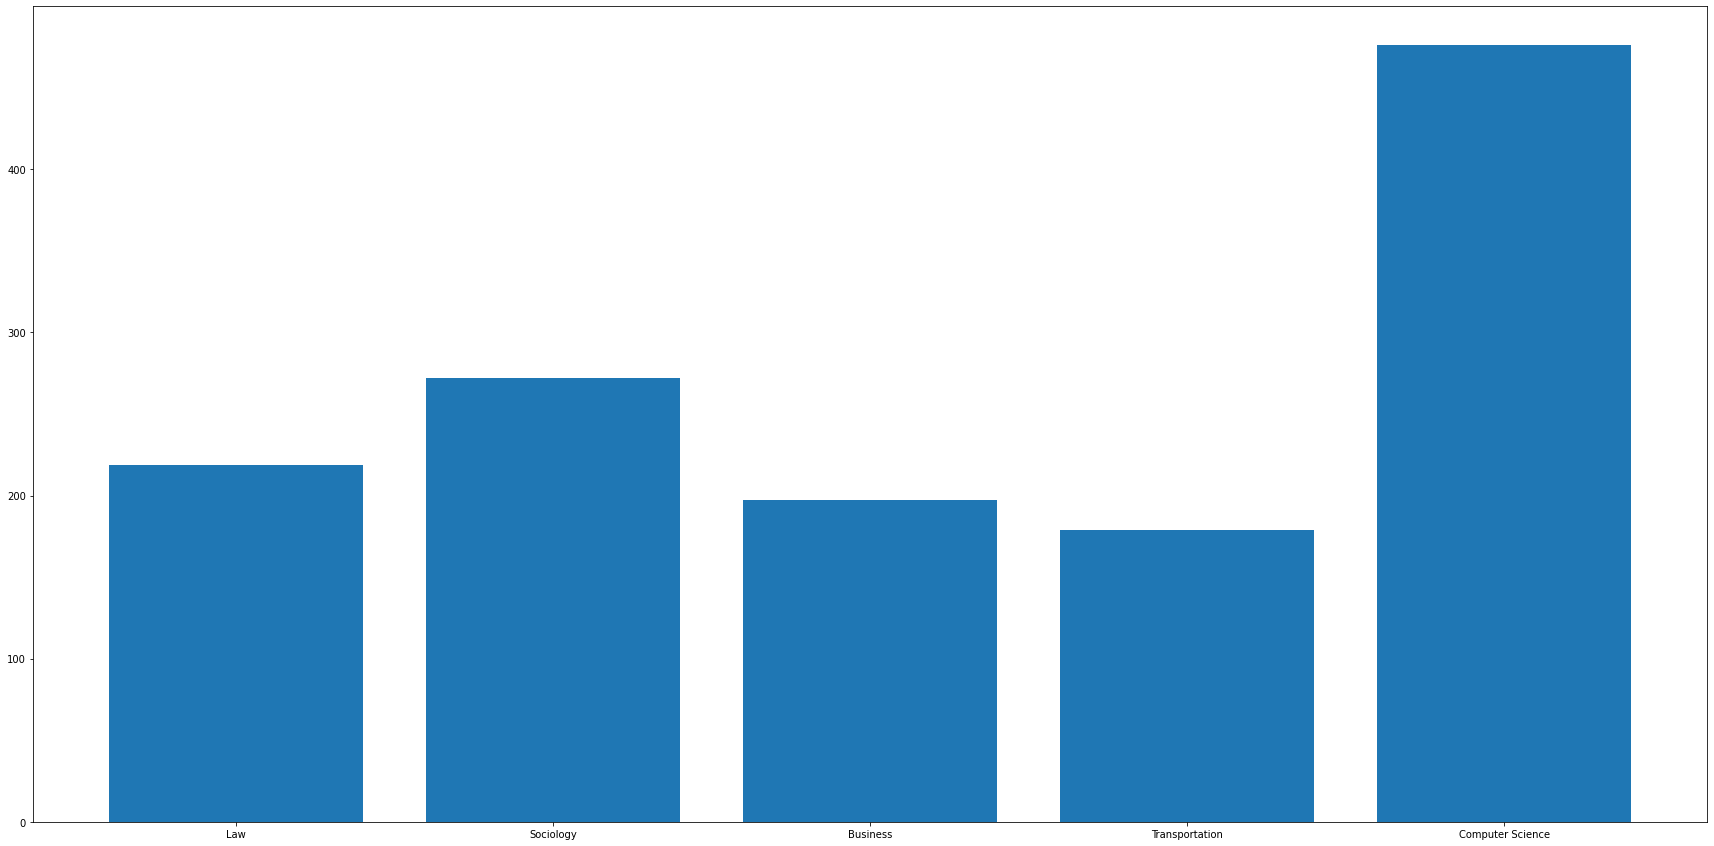

In [ ]:
plt.figure(figsize=(30, 15))
plt.bar(topics, np.diag(cm))

In [ ]:
p = probabilities
p.shape

torch.Size([6246, 5])

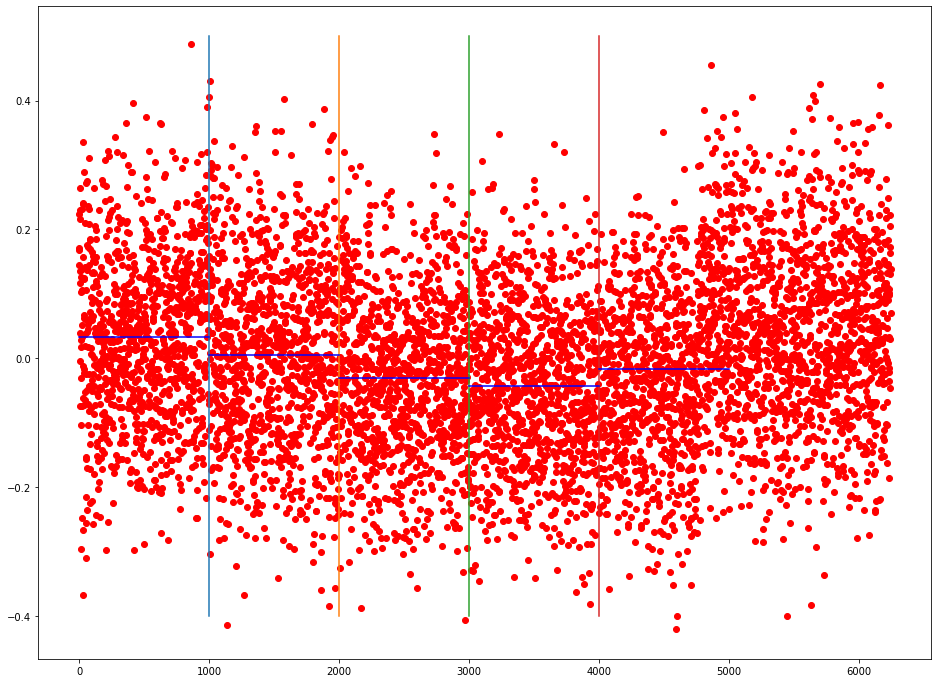

In [ ]:
classIdx1 = 4
classIdx2 = 3
plt.figure(figsize=(16, 12))
plt.plot(p[:, classIdx1], 'ro')
# plt.plot(p[:, classIdx2], 'bx')
# plt.plot(p[:, 0] - p[:, 3], 'ro')
plt.plot([1000, 1000], [-0.4, 0.5])
plt.plot([2000, 2000], [-0.4, 0.5])
plt.plot([3000, 3000], [-0.4, 0.5])
plt.plot([4000, 4000], [-0.4, 0.5])
plt.plot([0, 1000], [torch.mean(p[0:1000, classIdx1]), torch.mean(p[0:1000, classIdx1])], 'b')
plt.plot([1000, 2000], [torch.mean(p[1000:2000, classIdx1]), torch.mean(p[1000:2000, classIdx1])], 'b')
plt.plot([2000, 3000], [torch.mean(p[2000:3000, classIdx1]), torch.mean(p[2000:3000, classIdx1])], 'b')
plt.plot([3000, 4000], [torch.mean(p[3000:4000, classIdx1]), torch.mean(p[3000:4000, classIdx1])], 'b')
plt.plot([4000, 5000], [torch.mean(p[4000:5000, classIdx1]), torch.mean(p[4000:5000, classIdx1])], 'b')

### kNN with cosine similarity

In [ ]:
# Construct distances matrix
X = torch.zeros(size=(nSentences, len(topics) * nRelatedSentences))

start = 0
for (iTopic, topic) in enumerate(topics):
  print(topic)

  relatedEmbeddingsArr = relatedEmbeddingsPCA[iTopic]

  for iSentence in range(nSentences):
    nextFree = start
    for iKeyword in range(nRelatedSentences):
      X[iSentence][nextFree] = getSimilarity(embeddingsArr[iSentence], relatedEmbeddingsArr[iKeyword])
      nextFree += 1

  start += nRelatedSentences

y = np.asarray(df['label'])

Law
Sociology
Business
Transportation
Computer Science


In [ ]:
X.shape

torch.Size([6246, 500])

In [ ]:
ypred = np.zeros((nSentences, ))
y = np.asarray(df['label'])
# k = 15

acc = []
prec = []
rec  = []
f1   = []
rng = range(1, 200, 10)
for k in rng:
  for i in range(nSentences):
    idx = np.argpartition(X[i, :], -k)[-k:]

    tmpIdx = idx.clone().detach()
    tmpIdx[idx>=4*nRelatedSentences] = 4
    idx[idx>=4*nRelatedSentences] = -1

    tmpIdx[idx>=3*nRelatedSentences] = 3
    idx[idx>=3*nRelatedSentences] = -1

    tmpIdx[idx>=2*nRelatedSentences] = 2
    idx[idx>=2*nRelatedSentences] = -1

    tmpIdx[idx>=1*nRelatedSentences] = 1
    idx[idx>=1*nRelatedSentences] = -1

    tmpIdx[idx>0] = 0
    idx[idx>0] = -1
    
    ypred[i] = torch.mode(tmpIdx).values.item()

  acc.append(accuracy_score(y, ypred))
  prec.append(precision_score(y, ypred, average='weighted'))
  rec.append(recall_score(y, ypred, average='weighted'))
  f1.append(f1_score(y, ypred, average='weighted'))

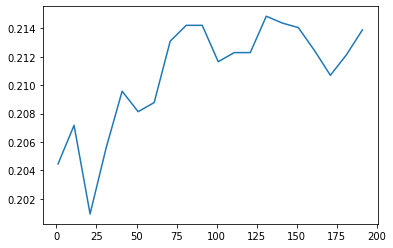

In [ ]:
plt.plot(rng, acc)

In [ ]:
idx = np.argmax(rec)
k = rng[idx]

print(k)
print('Precision: {:0.3f}'.format(prec[idx]))
print('Recall: {:0.3f}'.format(rec[idx]))
print('F1: {:0.3f}'.format(f1[idx]))


Text(123.0, 0.5, 'Actual')

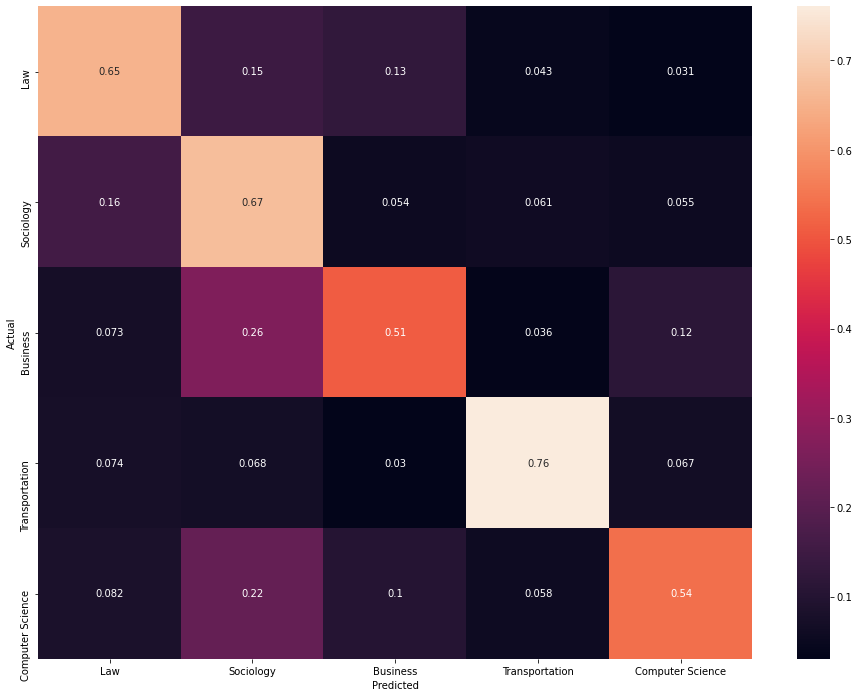

In [ ]:
cm = confusion_matrix(y, ypred)
cmNorm = torch.tensor(data=cm, dtype=float)
for i in range(len(cm)):
  cmNorm[i, :] = cmNorm[i, :]/torch.sum(cmNorm[i, :])

plt.figure(figsize=(16, 12))
sns.heatmap(cmNorm, annot=True, xticklabels=topics, yticklabels=topics)
plt.xlabel('Predicted')
plt.ylabel('Actual')

### kNN with distance metrics

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
nTopics = len(topics)

In [ ]:
nRelatedSentencesArr = [nRelatedSentences]*nTopics

In [ ]:
X = np.zeros((sum(nRelatedSentencesArr), 512))
ytrain = np.zeros((sum(nRelatedSentencesArr), 1))
for (iTopic, topic) in enumerate(topics):
  X[sum(nRelatedSentencesArr[0:iTopic]) : sum(nRelatedSentencesArr[0:iTopic+1]), :] = relatedEmbeddingsPCA[iTopic]
  ytrain[sum(nRelatedSentencesArr[0:iTopic]) : sum(nRelatedSentencesArr[0:iTopic+1])] = iTopic

In [ ]:
# ytrain = [0]*nRelatedSentences + [1]*nRelatedSentences + [2]*nRelatedSentences + [3]*nRelatedSentences + [4]*nRelatedSentences

In [ ]:
acc = []
rng = range(1, 20, 3)
for k in rng:
  knn = KNeighborsClassifier(n_neighbors=k, p=2, weights='distance')
  knn.fit(X, ytrain)
  ypred = knn.predict(embeddingsArr)
  acc.append(accuracy_score(y, ypred))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-

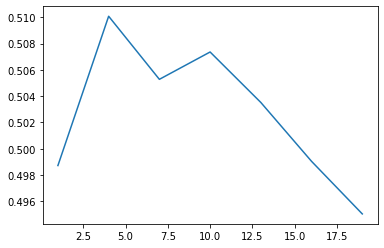

In [ ]:
plt.plot(rng, acc)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3, p=2, weights='distance')
knn.fit(X, ytrain)
ypred = knn.predict(embeddingsArr)
print(accuracy_score(y, ypred))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


0.5051232788984951


In [ ]:
print(precision_score(y, ypred, average=None))
print('Precision: {:0.3f}'.format(np.mean(precision_score(y, ypred, average='weighted'))))

print(recall_score(y, ypred, average=None))
print('Recall: {:0.3f}'.format(np.mean(recall_score(y, ypred, average='weighted'))))

print(f1_score(y, ypred, average=None))
print('F1: {:0.3f}'.format(np.mean(f1_score(y, ypred, average='weighted'))))

[0.47551867 0.37705999 0.54069224 0.71259569 0.65618861]
Precision: 0.569
[0.5695825  0.53358209 0.46166134 0.70718232 0.45504087]
Recall: 0.547
[0.5183175  0.44186945 0.49806118 0.70987868 0.53740949]
F1: 0.550


In [ ]:
cm = confusion_matrix(y, ypred)
cmNorm = torch.tensor(data=cm, dtype=float)
for i in range(len(cm)):
  cmNorm[i, :] = cmNorm[i, :]/torch.sum(cmNorm[i, :])

plt.figure(figsize=(16, 12))
sns.heatmap(cmNorm, annot=True, xticklabels=topics, yticklabels=topics)
plt.xlabel('Predicted')
plt.ylabel('Actual')